In [65]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt


In [4]:

url = 'https://raw.githubusercontent.com/PacktPublishing/TensorFlow-Developer-Certificate-Guide/main/Chapter%2012/sales_data.csv'
df = pd.read_csv(url)

In [54]:
sales = df['Sales'].values
split = int(0.8 * len(sales))
train_data = sales[:split]
val_data= sales[split:]


In [26]:
#converts the data column into a datetime format
df['Date'] = pd.to_datetime(df['Date'])
#change the date column by setting it as the index of our DataFrame
df.set_index('Date', inplace=True)

In [55]:
window_size = 30
batch_size=64
buffer_size=1000
def window_dataset(series, window_size, batch_size, buffer_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.map(lambda window:(window[:-1], window[-1]))
  dataset = dataset.shuffle(buffer_size)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [57]:
def create_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(128, input_shape=[window_size], activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])
  return model

In [58]:
lr_schedules ={
    'Exponential Decay' : tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01,
        decay_steps=100,
        decay_rate=0.96
    ),
    'Piecewise constant': tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [30,60],
        [0.1,0.01,0.001]
    ),
    'Polynomial decay': tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=0.1,
        decay_steps=100,
        end_learning_rate=0.01,
        power=1.0
    )
}

In [59]:
model = create_model()
loss = tf.keras.losses.mean_squared_error
optimizer= tf.keras.optimizers.Adam(learning_rate=lr_schedules['Polynomial decay'])
model.compile(loss=loss,
              optimizer=optimizer)
train_dataset = window_dataset(train_data, window_size, batch_size, buffer_size)
model.fit(train_dataset,
          epochs=100,
          verbose=1)


Epoch 1/100
46/46 [==============================] - 1s 8ms/step - loss: 437938.7812
Epoch 2/100
46/46 [==============================] - 0s 7ms/step - loss: 57.8494
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: 49.9401
Epoch 4/100
46/46 [==============================] - 0s 7ms/step - loss: 46.1250
Epoch 5/100
46/46 [==============================] - 1s 9ms/step - loss: 47.4112
Epoch 6/100
46/46 [==============================] - 1s 13ms/step - loss: 47.6979
Epoch 7/100
46/46 [==============================] - 1s 14ms/step - loss: 46.6977
Epoch 8/100
46/46 [==============================] - 1s 7ms/step - loss: 44.2374
Epoch 9/100
46/46 [==============================] - 0s 7ms/step - loss: 42.0449
Epoch 10/100
46/46 [==============================] - 0s 7ms/step - loss: 42.8776
Epoch 11/100
46/46 [==============================] - 0s 7ms/step - loss: 51.6220
Epoch 12/100
46/46 [==============================] - 0s 7ms/step - loss: 39.9405
Epoch 13/100
46/46 

In [60]:
def predict_model(model, series, window_size, batch_size, buffer_size):
  val_dataset = tf.data.Dataset.from_tensor_slices(series)
  val_dataset = val_dataset.window(window_size, shift=1, drop_remainder=True)
  val_dataset = val_dataset.flat_map(lambda w:w.batch(window_size))
  val_dataset = val_dataset.batch(batch_size).prefetch(1)
  forecast = model.predict(val_dataset)
  return forecast


In [64]:
forecast_series = sales[split-window_size:-1]
predictions = predict_model(model, forecast_series, window_size, batch_size, buffer_size)
results = predictions.squeeze().squeeze()

mae = tf.keras.metrics.mean_absolute_error(results, val_data)
mse = tf.keras.metrics.mean_squared_error(results, val_data)
print(f'mae : {mae} mse:{mse}')


12/12 [==============================] - 0s 10ms/step
mae : 4.755539551616204 mse:35.04032262026867


In [72]:
def plot_series(forecast,val, startDate=None, endDate=None ):
   plt.figure(figsize=(10,6))
   plt.plot(forecast, 'b', label="Forecast")
   plt.plot(val,'r', label="Actual validation")
   plt.legend()
   plt.show()



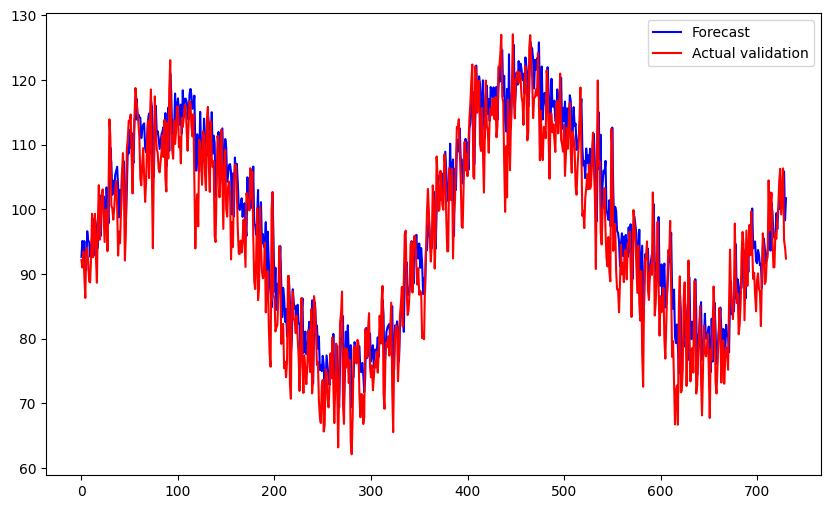

In [73]:
plot_series(results, val_data)